In [2]:
import functools
import time
from tqdm.notebook import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms

import matplotlib.pyplot as plt

In [3]:
def timer(func):
    @functools.wrap(func)
    def wrapper(*args, **kwargs):
        stime = time.perf_counter()
        res = func(*args, **kwargs)
        elapsed = time.perf_counter() - stime
        print(f"{func.__name__} in {elapsed:.4f} secs")
        return res
    return wrapper  

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# data
# we don't need labels for unconditional image generation
#data_mean = (0.491, 0.482, 0.447)
#data_std = (0.247, 0.243, 0.262)
train_tx = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(size=32, padding=4),
    transforms.ToTensor(), # [0,1]
    #transforms.Normalize(data_mean, data_std),
])

batch_size = 64
cifar10_ds = datasets.CIFAR10('data', train=True, download=True, transform=train_tx)
train_loader = torch.utils.data.DataLoader(cifar10_ds, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


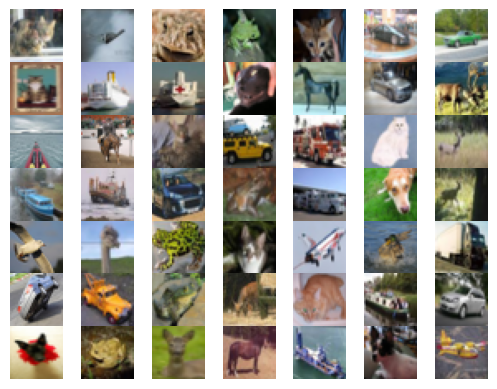

In [51]:
def show_images(idxs, nr=7, nc=7):
    if len(idxs) != nr * nc:
        idxs = np.random.randint(0, len(cifar10_ds), size=nr * nc)
        
    #fig = plt.figure(figsize=(nr/2, nc/2))
    fig = plt.figure()
    for i, idx in enumerate(idxs):
        img, label = cifar10_ds[idx]
        img = img.numpy().transpose(1, 2, 0)
        fig.add_subplot(nr, nc, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()
show_images([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

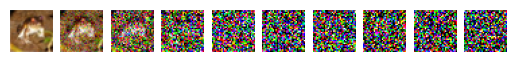

In [52]:
def linear_schedule(steps, st=0.0001, ed=0.02):
    return torch.linspace(st, ed, steps)

T = 1000
beta = linear_schedule(T)
alpha = 1 - beta
alphabar = torch.cumprod(alpha, axis=0)
beta = beta.to(device)
alpha = alpha.to(device)
alphabar = alphabar.to(device)

def forward_process(x0, t):
    '''
    aka diffusion process
    '''
    noise = torch.randn_like(x0).to(device)
    #xt = torch.sqrt(alphabar[t]) * x0 + (1 - alphabar[t]) * noise
    alphabar_t = alphabar[t].view(-1, *((1,) * (len(x0.shape) - 1))) # yes, we have batch    
    xt = torch.sqrt(alphabar_t) * x0 + (1 - alphabar_t) * noise
    return xt, noise

x0, _ = cifar10_ds[0]
fig = plt.figure()
for i, t in enumerate(range(0, T, T//10)):
    x0 = x0.to(device)
    xt, _ = forward_process(x0, t)
    
    fig.add_subplot(1, 10, i + 1)
    img = xt.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [49]:
tdim = 32 # time embedding dim

class BaseBlock(nn.Module):
    def __init__(self, inch, outch):
        super().__init__()
        self.tmlp = nn.Linear(tdim, outch)
        self.conv1 = nn.Conv2d(inch, outch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(outch)        
        self.conv2 = nn.Conv2d(outch, outch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(outch)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, t):
        x = self.relu(self.bn1(self.conv1(x)))
        temb = self.relu(self.tmlp(t))
        temb = temb[(...,) + (None, ) * 2]
        x = x + temb # time is added in addictive way (what about concat?)
        x = self.relu(self.bn2(self.conv2(x)))                     
        return x
    
class EncoderBlock(nn.Module):
    def __init__(self, inch, outch):
        super().__init__()
        self.base = BaseBlock(inch, outch)
        self.downsample = nn.MaxPool2d(2)
        
    def forward(self, x, t):
        x = self.base(x, t)
        y = self.downsample(x)
        return y, x

class DecoderBlock(nn.Module):
    def __init__(self, inch, outch):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(inch, outch, 2, 2)
        self.base = BaseBlock(inch, outch)
        
    def forward(self, x, f, t):
        x = self.upsample(x)
        x = torch.cat([x, f], dim=1)
        x = self.base(x, t)
        return x
    
class TimeEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        pass
        
    def forward(self, t):
        half_tdim = tdim // 2
        emb = np.log(10000) / (half_tdim - 1)
        emb = torch.exp(torch.arange(half_tdim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
        return emb
    
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # time embedding
        self.tmlp = nn.Sequential(
            TimeEmbedder(),
            nn.Linear(tdim, tdim),
            nn.ReLU())
        # encoder blocks
        self.enc1 = EncoderBlock(3, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        # bottom block
        self.bottom = BaseBlock(256, 512)
        # decoder blocks
        self.dec1 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec3 = DecoderBlock(128, 64)
        # final decode
        self.output = nn.Conv2d(64, 3, 1)
        
    def forward(self, x, t):
        t = self.tmlp(t)
        x, f1 = self.enc1(x, t)
        x, f2 = self.enc2(x, t)
        x, f3 = self.enc3(x, t)        
        x = self.bottom(x, t)
        x = self.dec1(x, f3, t)
        x = self.dec2(x, f2, t)
        x = self.dec3(x, f1, t)
        x = self.output(x)
        return x
        
net = SimpleUNet().to(device)
x = torch.randn(32, 3, 64, 64).to(device)
t = torch.randint(0, T, (32,), dtype=torch.float32).to(device)
print(net(x, t).shape)

torch.Size([32, 3, 64, 64])


In [55]:
def loss_func(model, x0, t):
    xt, noise = forward_process(x0, t) # t is used as index    
    noise_pred = model(xt, torch.tensor(t, dtype=torch.float32).to(device)) # t is used for time modulation
    loss = nn.functional.l1_loss(noise, noise_pred)
    return loss
    
# Without no_grad this quickly runs out of memory
@torch.no_grad()
def sample(x, t):
    noise_pred = model(x, t)
    mean_pred = 1 / np.sqrt(alpha[t]) * (x - beta[t] / np.sqrt(1 - alphabar[t]) * noise_pred)
    x_pred = mean_pred + (torch.randn_like(x) if t > 0 else 0)
    return x_pred

def train(model, dataloader, optimizer):
    model.train()  
    _loss = 0
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        t = np.random.randint(0, T, images.shape[0])        
        loss = loss_func(model, images, t)        
        loss.backward()
        optimizer.step()
        _loss = loss.item()
    _loss /= len(dataloader)
    return _loss

# main
epochs = 1
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_log = list()
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer)
    print(f"{epoch}/{epochs}: train_loss={train_loss:.6f}")
    train_log.append(train_loss)

0/1: train_loss=0.000219


In [73]:
a = torch.randn(3, 3, 8, 8, device="cuda")
b = torch.randn(3, device="cuda")
b = b.view(-1, *((1,) * (len(a.shape) - 1)))
b = torch.sqrt(b)
print(a.shape)
print(b.shape)
c = b * a
print(c.shape, c.get_device())

torch.Size([3, 3, 8, 8])
torch.Size([3, 1, 1, 1])
torch.Size([3, 3, 8, 8]) 0
